# Introduction

This notebook will go over the basic classifiers covered in the first lecture.  Additionally, the notebook has some (possibly) useful plotting code and it will cover the homework.  Below are the global libraries used in this introduction.  If any of do not import properly, just try running `pip install <library-name>` or Google how to install that library.  Most of them are very common and should come, ready-to-go, with your Python 2.7 installation, however.  

In [1]:
import cPickle
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline

# Loading Data

Below we will show you how to load in the ship and frog data that will be used for the introduction

In [2]:
f = open('frogs.pkl', 'r')
frog_imgs = cPickle.load(f)
f.close()

f = open('ships.pkl', 'r')
ship_imgs = cPickle.load(f)
f.close()

all_imgs = frog_imgs + ship_imgs
all_labels = [1 for _ in frog_imgs] + [0 for _ in ship_imgs]
all_imgs_labels = zip(all_imgs, all_labels)
random.seed(3.1415)
random.shuffle(all_imgs_labels)
del all_imgs
del all_labels

We split out data into 80% training and 20% test data.  

In [3]:
# percent training data
pct_train = 0.8
num_train = int(pct_train*len(all_imgs_labels))

# split into testing and training
train_imgs_labels, test_imgs_labels = all_imgs_labels[:num_train], all_imgs_labels[num_train:]

# Helper Functions

Here are a few helper functions to help you visualize the data

In [4]:
# calculate the average red, green, and blue pixels
def average_red_green_blue(raw_img):
    stride = 1024
    return np.average(raw_img[0*stride:1*stride]), np.average(raw_img[1*stride:2*stride]), np.average(raw_img[2*stride:3*stride])

# convert the raw image (a 1-d array) back to a 32x32x3 image
def to_img(raw_img):
    img_array = np.zeros((32, 32, 3), dtype='uint8')
    index = 0
    
    for i in range(3):
        for j in range(32):
            for k in range(32):
                img_array[j,k,i] = raw_img[index]
                index += 1
    return img_array

Sometimes we might want to visualize some of our images.  The following code lets us see them as images.  

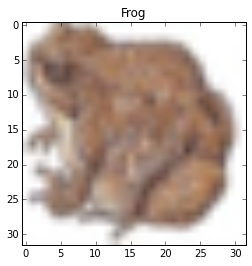

In [5]:
random_img, random_label = random.choice(train_imgs_labels)
plt.imshow(to_img(random_img))
plt.title('Frog' if random_label else 'Ship')
plt.show()

# Convert to Feature Space

To facilitate the conversion to feature space we write a simple function that lets us convert the data into feature space, for the purposes of this lecutre, that is x-axis (`green`) and y-axis (`blue`).  

In [6]:
def to_green_blue(raw_img, sf=1.):
    r, g, b = average_red_green_blue(raw_img)
    return np.asarray([float(g)/sf, float(b)/sf], dtype='float32')
    #return np.asarray([g, b])
XY_train = [(to_green_blue(raw_img), label) for raw_img, label in train_imgs_labels]
XY_test =  [(to_green_blue(raw_img), label) for raw_img, label in test_imgs_labels]

Next we want to visualize the data in feature space.  This can be done by creating a new image and rendering the little images inside of it

In [7]:
grid_size = 2000
grid_image = np.ones((grid_size, grid_size, 3), dtype='uint8')*255

# copy the list so we can shuffle it
tmp_img_label_list = list(all_imgs_labels)
random.seed(2016)
random.shuffle(tmp_img_label_list)

# we don't want to get too carried away with showing things
max_examples = 10000

# these will be how we display it on a plot later
xes = defaultdict(list)
yes = defaultdict(list)

# let's loop through all the images and labels
for index, (img, label) in enumerate(tmp_img_label_list):
    # first we get the x, y coordinates from the average r, g, b info
    r, g, b = average_red_green_blue(img)
    x = int(float(g)/255*grid_size)
    y = int(float(b)/255*grid_size)
    
    # put the image on our grid
    x1 = x-16
    x2 = x+16
    y1 = y-16
    y2 = y+16
    xes[label].append(g)
    yes[label].append(b)
    
    # now we check to make sure it's not outside the grid and draw it on the grid
    if x1 > 0 and x2 < grid_size and y1 > 0 and y2 < grid_size:
        grid_image[y1:y2,x1:x2,:] = to_img(img)
        
    if index > max_examples:
        break
        
del tmp_img_label_list

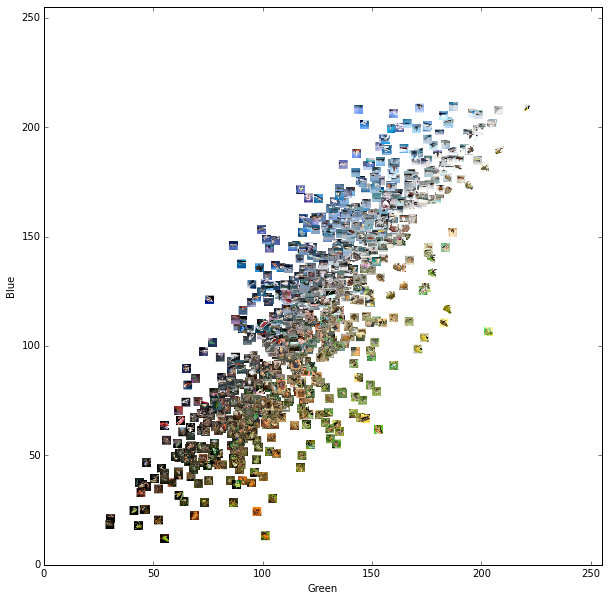

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(grid_image, origin='lowerleft', extent=[0, 255, 0, 255])
plt.xlabel('Green')
plt.ylabel('Blue')
plt.show()

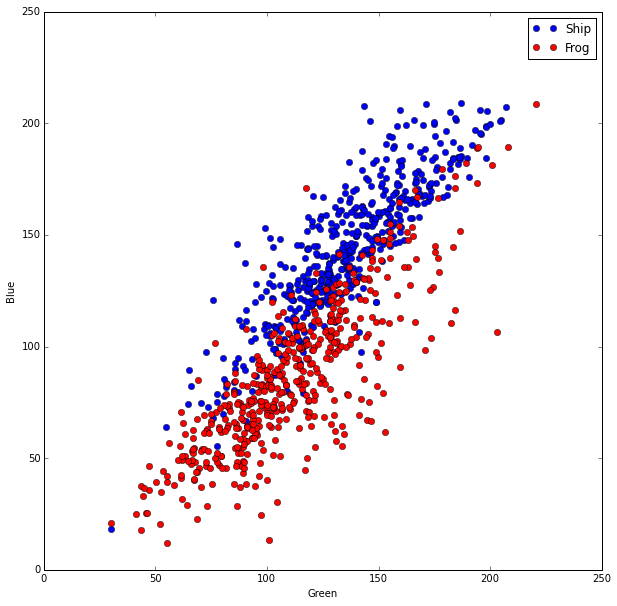

In [9]:
plt.figure(figsize=(10,10))
plt.plot(xes[0], yes[0], color='b', marker='o', linestyle='None', label='Ship')
plt.plot(xes[1], yes[1], color='r', marker='o', linestyle='None', label='Frog')
plt.xlabel('Green')
plt.ylabel('Blue')
plt.legend()
plt.show()

# Base Model

We include a virtual class below that will be inherited by the other models we build in the introduction.  This class has a `predict` method and a `test` method.  The `test` method lets us use a set of testing elements to determine the performance of the model.  

In [10]:
class BaseModel:
    def name(self):
        return 'Base Model'
    
    def predict(self, x):
        # always predict background
        return 0
    
    # calculates the performance of the model
    def test(self, XY_test, display=True):
        ses = []
        tp = 0.
        tn = 0.
        fp = 0.
        fn = 0.
        for x, y in XY_test:
            pred = self.predict(x)
            ses.append(y**2.+pred**2.)
            if y == 1:
                if pred >= 0.5:
                    tp += 1
                else:
                    fn += 1
            else:
                if pred < 0.5:
                    tn += 1
                else:
                    fp += 1
        try:
            accuracy = (tp+tn)/(tp+tn+fp+fn)
        except:
            accuracy = np.nan
        try:
            recall = tp/(tp+fn)
        except:
            recall = np.nan
        try:
            precision = tp/(tp+fp)
        except:
            precision = np.nan
            
        results = {'mse': np.mean(ses), 'accuracy': accuracy, 'recall': recall, 'precision': precision, 'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn}
        print "Fitted %s Results" % self.name()
        print "Accuracy: %0.2f%%" % (results['accuracy']*100.)
        print "Precision: %0.2f%%" % (results['precision']*100.)
        print "Recall: %0.2f%%" % (results['recall']*100.)
        return results
    
    # displays the model predictions on a grid for both test and training data
    # can also be used to save these plots to file
    def plot_model(self, XY_train, XY_test, display = True):
        x0es_test = {1: [], 0: []}
        x1es_test = {1: [], 0: []}
        for x, y in XY_test:
            x0es_test[y].append(x[0])
            x1es_test[y].append(x[1])

        x0es_train = {1: [], 0: []}
        x1es_train = {1: [], 0: []}
        for x, y in XY_train:
            x0es_train[y].append(x[0])
            x1es_train[y].append(x[1])

        x0min = min(x0es_test[0]+x0es_test[1])
        x0max = max(x0es_test[0]+x0es_test[1])
        x1min = min(x1es_test[0]+x1es_test[1])
        x1max = max(x1es_test[0]+x1es_test[1])

        numx0 = 50
        numx1 = int(np.ceil(numx0*(x1max-x1min)/(x0max-x0min)))
        dx0 = (x0max-x0min)/numx0
        dx1 = (x1max-x1min)/numx1
        values = np.zeros((numx1,numx0))
        for i in range(numx0):
            for j in range(numx1):
                x0 = x0min + i * dx0
                x1 = x1min + j * dx1
                values[j,i] = model.predict(np.asarray([x0,x1]))
                
        f, axarr = plt.subplots(1, 2, figsize=(16.,8.))
        the_extent = (x0min, x0max, x1min, x1max)

        axarr[0].plot(x0es_train[0], x1es_train[0], c='b', linestyle='None', marker='o')
        axarr[0].plot(x0es_train[1], x1es_train[1], c='r', linestyle='None', marker='o')
        axarr[0].imshow(values, cmap='bwr', interpolation='None', extent=the_extent, origin='lowerleft', alpha=1.0)
        axarr[0].set_title('%s (Train)' % model.name())

        axarr[1].plot(x0es_test[0], x1es_test[0], c='b', linestyle='None', marker='o')
        axarr[1].plot(x0es_test[1], x1es_test[1], c='r', linestyle='None', marker='o')
        axarr[1].imshow(values, cmap='bwr', interpolation='None', extent=the_extent, origin='lowerleft', alpha=1.0)
        axarr[1].set_title('%s (Test)' % model.name())

        if not display:
            plt.savefig('%s.jpg' % model.name())
        else:
            plt.show()

# Decision Tree

The decision tree is a simple model that asks questions to categorize the entries.  Normally there would be a training method that lets us use data to choose the proper class, but for now we'll just hard-code some cuts.  

In [11]:
class DecisionTree(BaseModel):
    def train(self, XY_train):
        print "Training is for losers who can't guess the correct answer!"
    
    def predict(self, x):
        if x[0] > 0.7*255:
            return 1 # frogs are green, let's say it's a frog
        elif x[1] > 0.5*255:
            return 0 # ships are blue-ish
        else:
            return 1 # I'm Nostradamus and it's a frog.

Fitted Base Model Results
Accuracy: 81.50%
Precision: 75.78%
Recall: 94.17%


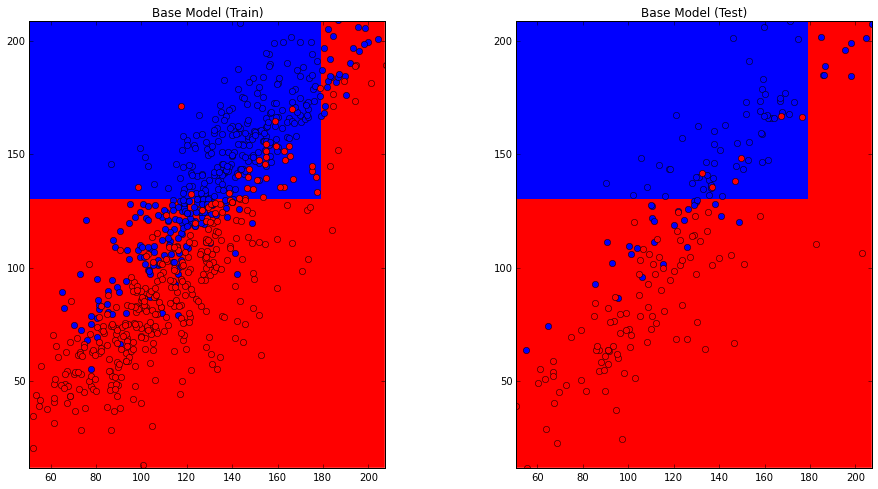

In [12]:
model = DecisionTree()
test_results = model.test(XY_test, display=True)
model.plot_model(XY_train, XY_test, display=False)

# Support Vector Machine

The SVM is one of the simplest models conceptually.  Fundamentally, we're simply finding a line that separates the signal from the background.  In higher dimensions this becomes a hyper-plane but the idea is the same.

In [13]:
class SVM(BaseModel):
    def train(self, XY_train):
        # calculate normal vector
        self.w = np.average(np.array([x for x, y in XY_train if y==1]), axis=0) \
               - np.average(np.array([x for x, y in XY_train if y==0]), axis=0)

        # calculate offset term
        self.b = 1./len(XY_train)*sum([np.dot(self.w,x)-float(y) for x, y in XY_train])
    def predict(self, x):
        # get sign and then scale it to the range (0,1)
        prediction = (np.sign(np.dot(self.w,x)-self.b)+1)/2
        return prediction
    
    def name(self):
        return 'SVM'

Fitted SVM Results
Accuracy: 85.00%
Precision: 86.87%
Recall: 83.50%


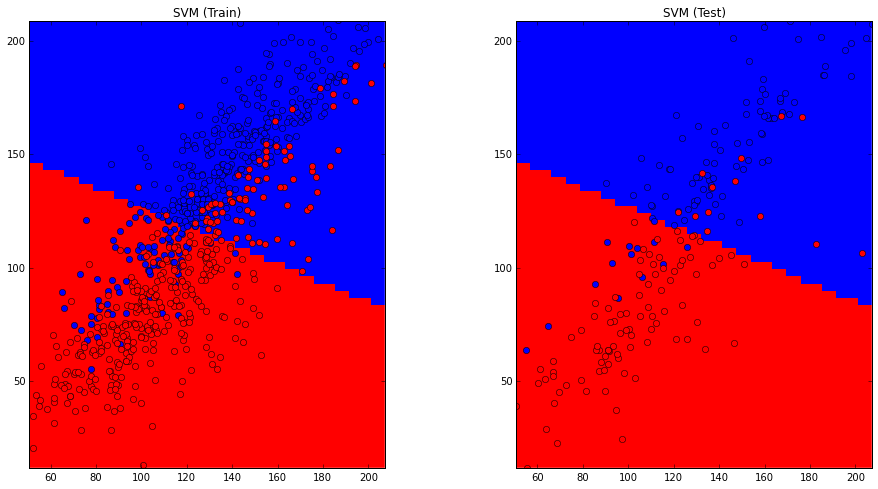

In [14]:
model = SVM()
model.train(XY_train)
test_results = model.test(XY_test, display=True)
model.plot_model(XY_train, XY_test, display=True)

# k-Nearest Neighbor

k-Nearest Neighbor is another simple model that is conceptually easy to understand.  Basically, the training data "votes" on what the label for an element should be.  Accordingly, it works very well for non-linear dependencies..  

In [15]:
class KNN(BaseModel):
    def train(self, XY_train, k=1):
        self.XY_train = XY_train
        self.k = k
    
    def predict(self, x):
        distance_label_list = [(np.linalg.norm(x-x_train), y_train) for x_train, y_train in self.XY_train]
        distance_label_list.sort()
        return np.average([label for distance, label in distance_label_list[:self.k]])
    
    def name(self):
        return 'kNN-%i' % self.k

## k=1 Model

Fitted kNN-1 Results
Accuracy: 86.00%
Precision: 87.88%
Recall: 84.47%


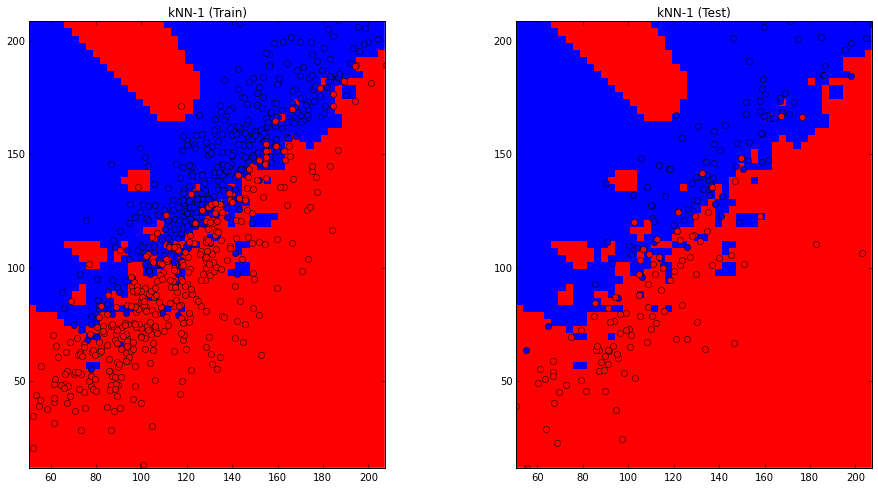

In [16]:
k = 1
model = KNN()
model.train(XY_train, k)
test_results = model.test(XY_test, display=True)
model.plot_model(XY_train, XY_test, display=True)

## k=10 Model

Fitted kNN-10 Results
Accuracy: 86.00%
Precision: 86.41%
Recall: 86.41%


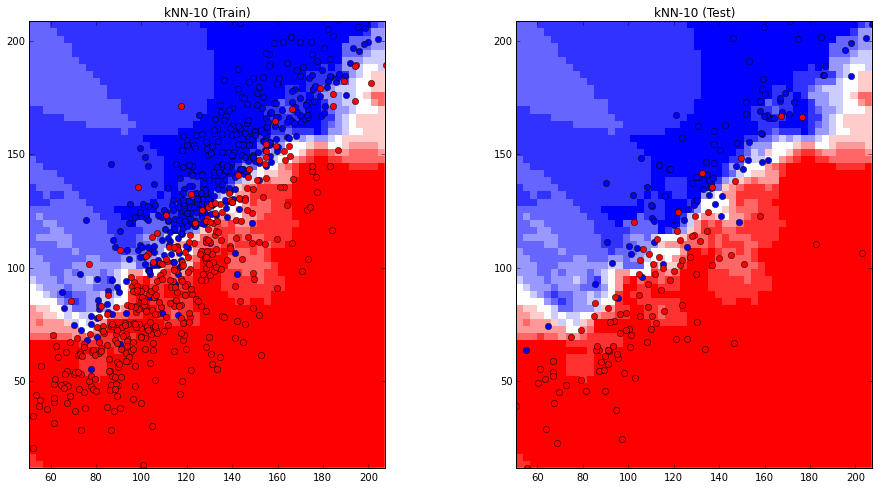

In [17]:
k = 10
model = KNN()
model.train(XY_train, k)
test_results = model.test(XY_test, display=True)
model.plot_model(XY_train, XY_test, display=True)

# Homework 1

## Add the color: RED
By modifying code written above, try training a `kNN` or `SVM` using 3-input colors (`red`, `green`, `blue`) rather than the 2-input colors (`green`, `blue`) that we used above.  

Steps:
1.  Transform the raw data to `red`, `green`, `blue` feature space
2.  Use this new `XY_train` to train the kNN or SVM
3.  How does the performance of this new classifier compare to that of the original 2-input classifiers?

## Write a Deeper Decision Tree
We already saw a very simple decision tree in class (`green` vs `not green`).  Try modifying the hard-coded cuts on the `green` and `blue` components to improve the performance of the decision.  How good can you make your Decision Tree classifier?  Can you make it better by layering more `if`-statements (i.e. making it a `deeper` decision tree)?  

## BONUS:
Write an algorithm that automatically trains the decision tree using the `XY_train` input data.  It doesn't need to be complex, it just learns at least one `cut` from distribution of points in the training data.  